# Experimentaci√≥n paper 7 Clustering y clasificaci√≥n

## Librer√≠as

In [1]:
import requests
from bs4 import BeautifulSoup


In [2]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, time, joblib
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import yfinance as yf
from ripser import ripser
from persim import PersistenceImager, plot_diagrams
import pywt
import umap.umap_ as umap
#from umap import UMAP
import collections
collections.Iterable = collections.abc.Iterable
from sklearn.metrics import ConfusionMatrixDisplay

from statsmodels.tsa.stattools import acf
np.random.seed(42)


C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Datos

In [3]:
START_DATE = "2025-01-01"
END_DATE = "2025-10-01"


# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petici√≥n con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B']
Found 503 weights
First 10 weights: ['7.75%', '6.34%', '6.19%', '3.92%', '3.00%', '2.67%', '2.48%', '2.35%', '2.32%', '1.76%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']


C:\Users\a01286222\AppData\Local\Temp\ipykernel_23380\426581270.py:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [4]:
# -----------------------------
# Descargar precios hist√≥ricos
# -----------------------------
tickers_data = yf.download(tickers, start=START_DATE, auto_adjust=True)['Close']
tickers_data = tickers_data.dropna(axis=1)  # eliminar columnas con datos faltantes

[*********************100%***********************]  503 of 503 completed



In [5]:
#tickers y categor√≠as
# Obtener las categor√≠as de los tickers usando yfinance
categories = {}
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        sector = info.get('sector', 'Unknown')
        if sector not in categories:
            categories[sector] = []
        categories[sector].append(ticker)
    except Exception as e:
        print(f"Error obteniendo sector para {ticker}: {e}")

print("Categor√≠as encontradas:", {k: len(v) for k, v in categories.items()})


Categor√≠as encontradas: {'Technology': 81, 'Consumer Cyclical': 55, 'Communication Services': 25, 'Financial Services': 69, 'Consumer Defensive': 37, 'Healthcare': 60, 'Energy': 22, 'Industrials': 72, 'Basic Materials': 20, 'Utilities': 31, 'Real Estate': 31}


In [6]:
'''#tickers y categor√≠as
categories = {
    "Banking": ["JPM", "WFC", "GS", "MS"],  # Categor√≠a 1:banca
    "Tech": ["AAPL", "MSFT", "GOOGL", "AMZN"],  # Categor√≠a 2:Tecnolog√≠a
    "Energy": ["XOM", "CVX", "BP", "SLB"],  # Categor√≠a 3:Energ√≠a
}'''

#Descargar los datos de cierre  para todos los tickers
all_tickers = [ticker for group in categories.values() for ticker in group]


df = yf.download(all_tickers, start=START_DATE, end=END_DATE, progress=False)     ####
close = df['Close'].dropna(how='all')                                                   ####

#guardamos df en un csv
#close.to_csv("stocks_experimento_3.csv")
#close = pd.read_csv("stocks_experimento_3.csv", index_col=0, parse_dates=True)
display(close.head())

#crear un DataFrame con las categor√≠as
ticker_categories = {}
for category, tickers in categories.items():
    for ticker in tickers:
        ticker_categories[ticker] = category

#Crear un DataFrame con las categor√≠as asignadas
category_df = pd.DataFrame.from_dict(ticker_categories, orient="index", columns=["Category"])
print(category_df)
#asegurars ede que las categorias esten alineadas coerrectamente
close = close[close.columns.intersection(category_df.index)]

#Asignar las categor√≠as como etiquetas
labels = [ticker_categories[ticker] for ticker in close.columns]

#Mostrar los datos y etiquetas
print("Datos descargados:")
print(close.head())
print("\nEtiquetas (categor√≠as):")
print(labels)

C:\Users\a01286222\AppData\Local\Temp\ipykernel_23380\1061747705.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(all_tickers, start=START_DATE, end=END_DATE, progress=False)     ####


Ticker               A        AAPL        ABBV        ABNB         ABT  \
Date                                                                     
2025-01-02  132.601044  242.987427  174.627625  131.479996  111.825531   
2025-01-03  134.847000  242.499146  176.359894  135.710007  112.209991   
2025-01-06  135.582397  244.133347  175.269928  135.199997  111.431221   
2025-01-07  136.556320  241.353226  174.715210  131.289993  111.786102   
2025-01-08  136.148865  241.841476  173.712830  130.800003  112.624008   

Ticker           ACGL         ACN        ADBE         ADI        ADM  ...  \
Date                                                                  ...   
2025-01-02  91.379997  343.909943  441.000000  208.655472  48.741325  ...   
2025-01-03  91.400002  348.869141  430.570007  212.624191  48.576328  ...   
2025-01-06  90.739998  346.384583  431.179993  215.220673  48.168697  ...   
2025-01-07  92.250000  351.373413  422.630005  213.117813  47.974586  ...   
2025-01-08  92.660004  352.694550  419.579987  217.629562  48.372517  ...   

Ticker             WY       WYNN        XEL         XOM         XYL  \
Date                                                                  
2025-01-02  27.348219  83.165047  64.710701  104.416367  114.904846   
2025-01-03  27.709736  82.688683  64.546165  104.951553  116.123764   
2025-01-06  27.846525  83.968910  63.568344  104.834785  115.786819   
2025-01-07  27.367762  81.825264  64.056274  105.817543  114.736374   
2025-01-08  27.045326  80.554962  64.788185  104.046631  114.865211   

Ticker            XYZ         YUM         ZBH        ZBRA         ZTS  
Date                                                                   
2025-01-02  86.750000  131.643906  103.713173  383.760010  161.036179  
2025-01-03  92.160004  131.525620  103.723114  391.859985  161.729385  
2025-01-06  91.940002  128.302536  102.819611  395.329987  164.294327  
2025-01-07  87.680000  126.705780  102.392685  396.109985  161.907669  
2025-01-08  86.750000  125.907387  100.814049  397.000000  163.422867  

[5 rows x 503 columns]

         Category
NVDA   Technology
MSFT   Technology
AAPL   Technology
AVGO   Technology
ORCL   Technology
...           ...
UDR   Real Estate
BXP   Real Estate
HST   Real Estate
CPT   Real Estate
FRT   Real Estate

[503 rows x 1 columns]
Datos descargados:
Ticker               A        AAPL        ABBV        ABNB         ABT  \
Date                                                                     
2025-01-02  132.601044  242.987427  174.627625  131.479996  111.825531   
2025-01-03  134.847000  242.499146  176.359894  135.710007  112.209991   
2025-01-06  135.582397  244.133347  175.269928  135.199997  111.431221   
2025-01-07  136.556320  241.353226  174.715210  131.289993  111.786102   
2025-01-08  136.148865  241.841476  173.712830  130.800003  112.624008   

Ticker           ACGL         ACN        ADBE         ADI        ADM  ...  \
Date                                                                  ...   
2025-01-02  91.379997  343.909943  441.000000  208.655472  48.741325

## Preprocesamiento

In [7]:
W = 30  # Ventana de tiempo

In [8]:
returns = np.log(close).diff().dropna()
# ACF por ticker (usar primer lag donde acf < 1/e)
from statsmodels.tsa.stattools import acf
def choose_tau(series, threshold=0.2):
    ac = acf(series, nlags=50, fft=True)
    for k in range(1, len(ac)):
        if abs(ac[k]) < threshold:
            return k
    return 1

taus = {t: choose_tau(returns[t].dropna()) for t in returns.columns}
print("taus:", taus)

# Ventanas (no solapadas para demo r√°pido)

step = W #step es igual a W para que no se entrelacen y cada uno tenga datos distintos sin repetir
def sliding_windows(series, window=W, step=step):
    x = series.values
    return np.array([x[i:i+window] for i in range(0, len(x)-window+1, step)])
Xwins = {}
for t in returns.columns:
    Xwins[t] = sliding_windows(returns[t].dropna())
    print(t, Xwins[t].shape)


taus: {'A': 1, 'AAPL': 1, 'ABBV': 1, 'ABNB': 1, 'ABT': 1, 'ACGL': 1, 'ACN': 1, 'ADBE': 1, 'ADI': 1, 'ADM': 1, 'ADP': 1, 'ADSK': 1, 'AEE': 1, 'AEP': 1, 'AES': 1, 'AFL': 1, 'AIG': 1, 'AIZ': 1, 'AJG': 1, 'AKAM': 1, 'ALB': 1, 'ALGN': 1, 'ALL': 1, 'ALLE': 1, 'AMAT': 1, 'AMCR': 1, 'AMD': 1, 'AME': 1, 'AMGN': 1, 'AMP': 1, 'AMT': 1, 'AMZN': 1, 'ANET': 1, 'AON': 1, 'AOS': 1, 'APA': 1, 'APD': 1, 'APH': 1, 'APO': 1, 'APP': 1, 'APTV': 1, 'ARE': 1, 'ATO': 1, 'AVB': 1, 'AVGO': 1, 'AVY': 1, 'AWK': 1, 'AXON': 1, 'AXP': 1, 'AZO': 1, 'BA': 1, 'BAC': 1, 'BALL': 1, 'BAX': 1, 'BBY': 1, 'BDX': 1, 'BEN': 1, 'BF-B': 1, 'BG': 1, 'BIIB': 1, 'BK': 1, 'BKNG': 1, 'BKR': 1, 'BLDR': 1, 'BLK': 1, 'BMY': 1, 'BR': 1, 'BRK-B': 1, 'BRO': 1, 'BSX': 1, 'BX': 1, 'BXP': 1, 'C': 1, 'CAG': 1, 'CAH': 1, 'CARR': 1, 'CAT': 1, 'CB': 1, 'CBOE': 1, 'CBRE': 1, 'CCI': 1, 'CCL': 1, 'CDNS': 1, 'CDW': 1, 'CEG': 1, 'CF': 1, 'CFG': 1, 'CHD': 1, 'CHRW': 1, 'CHTR': 1, 'CI': 1, 'CINF': 1, 'CL': 1, 'CLX': 1, 'CMCSA': 1, 'CME': 1, 'CMG': 1, 'CM

## Embedding

In [9]:
#Estas dos funciones don diferentes opciones para basicamente lo mismo
# la segunda es una version qu evi en mi clase de topolog√≠a

def time_delay_embedding(window, d=3, tau=0):
    W = len(window)
    m = W - (d-1)*tau
    emb = np.vstack([window[i:i+m] for i in range(0, d*tau, tau)]).T
    return emb

def embed(points,d=2,tau=1):
    auxembed=[]
    for i in range(0,len(points)-d+1):
        aux=[points[i+j] for j in range(d)]
        auxembed.append(aux)
    auxembed=np.array(auxembed)
    return auxembed

In [10]:




'''
# Procesar por categor√≠as
for category, tickers_in_category in categories.items():
    print(f"Procesando categor√≠a: {category}")
    
    # Combinar las ventanas de todos los tickers en esta categor√≠a
    category_windows = []
    for ticker in tickers_in_category:
        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual
    
    # Tomar la primera ventana de la categor√≠a para el ejemplo
    w = category_windows[0]
    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categor√≠a
    print("Ejemplo ventana:", w, "tau0:", tau0)
    
    # Hacer el embedding
    emb = time_delay_embedding(w, d=2, tau=tau0)
    
    #diagrama de persistencia
    dgms = ripser(StandardScaler().fit_transform(emb), maxdim=1)['dgms']
    plt.figure(figsize=(6, 4))  
    plot_diagrams(dgms)
    plt.title(f"Persistence Diagram - Categor√≠a: {category}")
    plt.show()'''


'\n# Procesar por categor√≠as\nfor category, tickers_in_category in categories.items():\n    print(f"Procesando categor√≠a: {category}")\n\n    # Combinar las ventanas de todos los tickers en esta categor√≠a\n    category_windows = []\n    for ticker in tickers_in_category:\n        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual\n\n    # Tomar la primera ventana de la categor√≠a para el ejemplo\n    w = category_windows[0]\n    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categor√≠a\n    print("Ejemplo ventana:", w, "tau0:", tau0)\n\n    # Hacer el embedding\n    emb = time_delay_embedding(w, d=2, tau=tau0)\n\n    #diagrama de persistencia\n    dgms = ripser(StandardScaler().fit_transform(emb), maxdim=1)[\'dgms\']\n    plt.figure(figsize=(6, 4))  \n    plot_diagrams(dgms)\n    plt.title(f"Persistence Diagram - Categor√≠a: {category}")\n    plt.show()'

## Compute tda features

Procesando categor√≠a: Technology


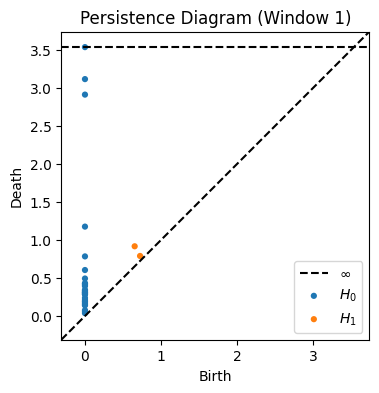

Procesando categor√≠a: Consumer Cyclical


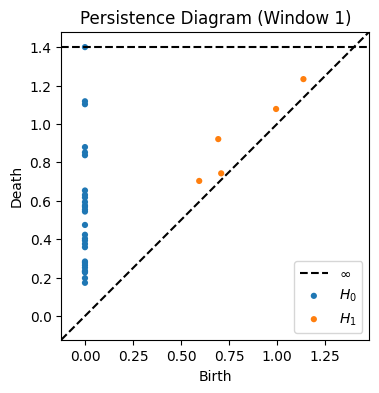

Procesando categor√≠a: Communication Services


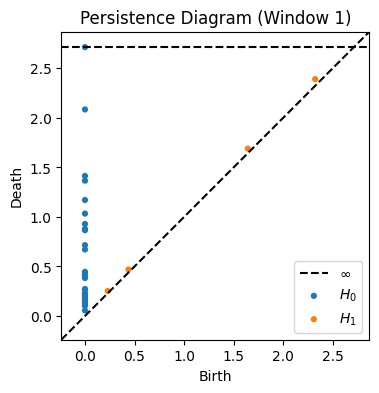

Procesando categor√≠a: Financial Services


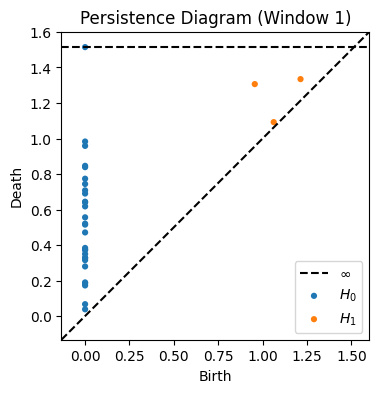

Procesando categor√≠a: Consumer Defensive


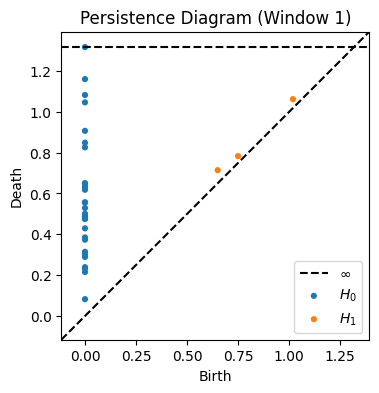

Procesando categor√≠a: Healthcare


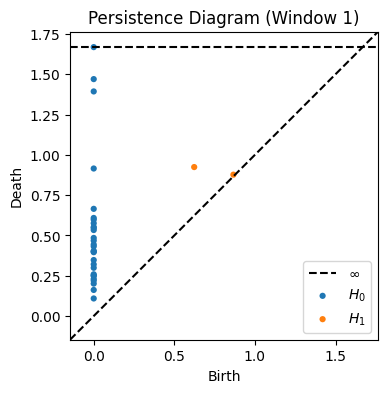

Procesando categor√≠a: Energy


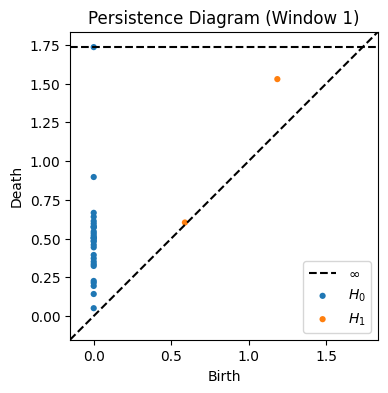

Procesando categor√≠a: Industrials


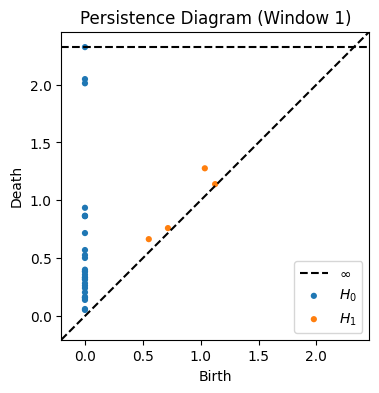

Procesando categor√≠a: Basic Materials


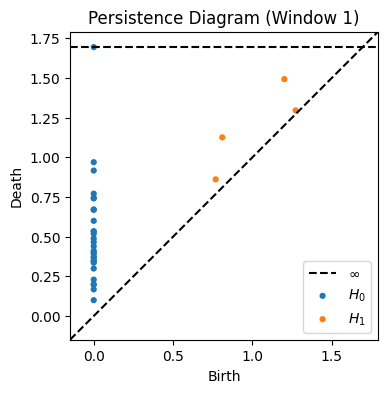

Procesando categor√≠a: Utilities


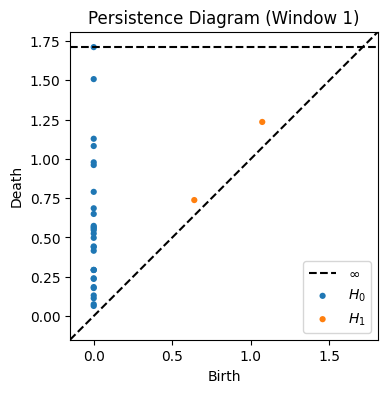

Procesando categor√≠a: Real Estate


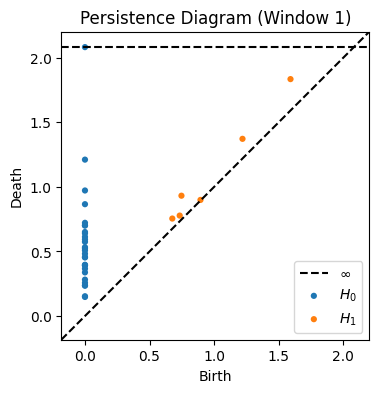

X_imgs shape: (3018, 442)


In [11]:
# convertimos ventanas a diagrams y luego a persistence images
def windows_to_diagrams(Xwins_for_category, d=3, tau=1, maxdim=1):
    diagrams = []
    for i,w in enumerate(Xwins_for_category):
        emb = time_delay_embedding(w, d=d, tau=tau) # embed o time_delay_embedding
        emb_s = StandardScaler().fit_transform(emb)
        dgms = ripser(emb_s, maxdim=maxdim)['dgms']
        # Concatenate H0 and H1, and filter out infinite values
        finite_dgms = [dgm[np.isfinite(dgm).all(axis=1)] for dgm in dgms]
        diagrams.append(np.vstack(finite_dgms))
        #graficar algunos de los persistence diagrams 
        if i < 1:  # Graficar solo la primera ventana por categoria, esto cambialo a como quieras, lo dejo as√≠ para ahorrar espacio
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(111)
            plot_diagrams(dgms, ax=ax, show=False)
            ax.set_title(f"Persistence Diagram (Window {i+1})")
            plt.show()

    return diagrams





# Ejemplo: hacerlo para todos los tickers (usa menos ventanas para demo r√°pido)
all_diagrams = []
labels = []
'''for t in tickers:
    # tomar s√≥lo primeras N windows si hay muchas
    nmax = 30
    diags = windows_to_diagrams(Xwins[t][:nmax], d=2, tau=taus[t], maxdim=1)
    all_diagrams.extend(diags)
    labels.extend([t]*len(diags))
'''

for category, tickers_in_category in categories.items():
    print(f"Procesando categor√≠a: {category}")
    
    # Combinar las ventanas de todos los tickers en esta categor√≠a
    category_windows = []
    for ticker in tickers_in_category:
        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual
    
    # Tomar s√≥lo las primeras N ventanas si hay muchas
    nmax = 30
    category_windows = category_windows[:]
    
    # Calcular diagramas de persistencia para la categor√≠a
    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categor√≠a
    diags = windows_to_diagrams(category_windows, d=2, tau=tau0, maxdim=1)
    all_diagrams.extend(diags)
    labels.extend([category] * len(diags))  # Usar la categor√≠a como etiqueta



# PersistenceImager (fit con todos)
pim = PersistenceImager(pixel_size=0.2, birth_range=(0,1))
pim.fit(all_diagrams)
X_imgs = np.array([pim.transform(dgm).ravel() for dgm in all_diagrams])
print("X_imgs shape:", X_imgs.shape)


## Train RF 

In [12]:
'''# Codificar las categor√≠as como etiquetas
le = LabelEncoder(); y = le.fit_transform(labels)

X = X_imgs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# opcional: reducci√≥n de dimensi√≥n si X es muy grande
from sklearn.decomposition import TruncatedSVD
if X.shape[1] > 250:
    svd = TruncatedSVD(n_components=200, random_state=42)
    X_train = svd.fit_transform(X_train)
    X_test = svd.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy RF-TDA:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Mostrar la importancia de las caracter√≠sticas
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Importancia de las caracter√≠sticas")
plt.xlabel("√çndice de caracter√≠stica")
plt.ylabel("Importancia")
plt.show()

'''



'# Codificar las categor√≠as como etiquetas\nle = LabelEncoder(); y = le.fit_transform(labels)\n\nX = X_imgs\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\n\n# opcional: reducci√≥n de dimensi√≥n si X es muy grande\nfrom sklearn.decomposition import TruncatedSVD\nif X.shape[1] > 250:\n    svd = TruncatedSVD(n_components=200, random_state=42)\n    X_train = svd.fit_transform(X_train)\n    X_test = svd.transform(X_test)\n\nrf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)\nrf.fit(X_train, y_train)\n\ny_pred = rf.predict(X_test)\n\nprint("Accuracy RF-TDA:", accuracy_score(y_test, y_pred))\nprint(classification_report(y_test, y_pred, target_names=le.classes_))\n\n# Mostrar la importancia de las caracter√≠sticas\nimportances = rf.feature_importances_\nplt.figure(figsize=(10, 6))\nplt.bar(range(len(importances)), importances)\nplt.title("Importancia de las caracter√≠sticas")\nplt.xlabel("√çndice de caracter√≠stic

In [13]:
'''# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusi√≥n")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')'''

'# Matriz de confusi√≥n\ncm = confusion_matrix(y_test, y_pred)\nprint(confusion_matrix(y_test, y_pred))\nplt.figure(figsize=(6, 5))\nsns.heatmap(cm, annot=True, fmt=\'d\', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")\nplt.title("Matriz de Confusi√≥n")\nplt.xlabel("Predicted Labels")\nplt.ylabel("True Labels")\nplt.tight_layout()\nplt.show()\n\nConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize=\'true\')'

In [14]:
#print("Shape of X_imgs:", X_imgs.shape)

In [15]:
# =======================================================
# üöÄ MEJORAS PARA GENERACI√ìN DE DATOS DE ENTRENAMIENTO
# =======================================================

print("üìä An√°lisis de datos antes de mejoras:")
print(f"Shape original X_imgs: {X_imgs.shape}")
print(f"N√∫mero de muestras por categor√≠a: {pd.Series(labels).value_counts()}")
print(f"Distribuci√≥n de clases: {pd.Series(labels).value_counts(normalize=True)}")

# 1. BALANCEO DE CLASES CON ESTRATEGIAS AVANZADAS
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

# Codificar labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

print(f"\nüéØ Distribuci√≥n original de clases:")
for i, class_name in enumerate(le.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {class_name}: {count} muestras ({count/len(y_encoded)*100:.1f}%)")

# Estrategia 1: SMOTE para balanceo inteligente
print("\nüîÑ Aplicando SMOTE para balancear clases...")
smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced_smote, y_balanced_smote = smote.fit_resample(X_imgs, y_encoded)

print(f"Despu√©s de SMOTE: {X_balanced_smote.shape}")
print(f"Distribuci√≥n balanceada: {Counter(y_balanced_smote)}")

# Estrategia 2: Combinaci√≥n SMOTETomek (m√°s conservadora)
print("\nüîÑ Aplicando SMOTETomek...")
smote_tomek = SMOTETomek(random_state=42)
X_balanced_hybrid, y_balanced_hybrid = smote_tomek.fit_resample(X_imgs, y_encoded)

print(f"Despu√©s de SMOTETomek: {X_balanced_hybrid.shape}")
print(f"Distribuci√≥n h√≠brida: {Counter(y_balanced_hybrid)}")

# 2. AUMENTACI√ìN DE DATOS ESPEC√çFICA PARA TDA
def augment_persistence_images(X, factor=2):
    """Aumenta datos a√±adiendo ruido gaussiano peque√±o a persistence images"""
    X_augmented = []
    
    for _ in range(factor):
        # A√±adir ruido muy peque√±o (no queremos cambiar mucho la topolog√≠a)
        noise = np.random.normal(0, 0.01, X.shape)
        X_noisy = X + noise
        # Asegurar que no haya valores negativos (las persistence images son no-negativas)
        X_noisy = np.maximum(X_noisy, 0)
        X_augmented.append(X_noisy)
    
    return np.vstack(X_augmented)

print("\nüé® Aplicando aumentaci√≥n espec√≠fica para TDA...")
X_augmented = augment_persistence_images(X_imgs, factor=2)
y_augmented = np.tile(y_encoded, 3)  # Original + 2 aumentadas

print(f"Despu√©s de aumentaci√≥n: {X_augmented.shape}")
print(f"Labels aumentadas: {len(y_augmented)}")

# 3. SELECCI√ìN DE CARACTER√çSTICAS MEJORADA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import ExtraTreesClassifier

print("\nüéØ Selecci√≥n de caracter√≠sticas avanzada...")

# M√©todo 1: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(150, X_imgs.shape[1]))
X_selected_mi = selector_mi.fit_transform(X_imgs, y_encoded)

# M√©todo 2: RFE con ExtraTrees
et_selector = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe = RFE(estimator=et_selector, n_features_to_select=min(100, X_imgs.shape[1]))
X_selected_rfe = rfe.fit_transform(X_imgs, y_encoded)

print(f"Features seleccionadas (MI): {X_selected_mi.shape[1]}")
print(f"Features seleccionadas (RFE): {X_selected_rfe.shape[1]}")

# 4. VALIDACI√ìN CRUZADA ESTRATIFICADA
from sklearn.model_selection import StratifiedKFold
print(f"\n‚úÖ Datos mejorados preparados para entrenamiento!")

üìä An√°lisis de datos antes de mejoras:
Shape original X_imgs: (3018, 442)
N√∫mero de muestras por categor√≠a: Technology                486
Industrials               432
Financial Services        414
Healthcare                360
Consumer Cyclical         330
Consumer Defensive        222
Real Estate               186
Utilities                 186
Communication Services    150
Energy                    132
Basic Materials           120
Name: count, dtype: int64
Distribuci√≥n de clases: Technology                0.161034
Industrials               0.143141
Financial Services        0.137177
Healthcare                0.119284
Consumer Cyclical         0.109344
Consumer Defensive        0.073559
Real Estate               0.061630
Utilities                 0.061630
Communication Services    0.049702
Energy                    0.043738
Basic Materials           0.039761
Name: proportion, dtype: float64

üéØ Distribuci√≥n original de clases:
  Basic Materials: 120 muestras (4.0%)
  Communi

### Optimizado

In [ ]:
# =======================================================
# üå≤ RANDOM FOREST OPTIMIZADO CON MEJORES PR√ÅCTICAS
# =======================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import time

# 1. B√öSQUEDA DE HIPERPAR√ÅMETROS INTELIGENTE
print("üîç Optimizaci√≥n de hiperpar√°metros con RandomizedSearchCV...")

# Par√°metros para buscar (m√°s eficiente que GridSearch)
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Usar datos balanceados para b√∫squeda
X_search = X_balanced_smote
y_search = y_balanced_smote

# Split estratificado
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_search, y_search, test_size=0.2, stratify=y_search, random_state=42
)

# RandomizedSearchCV (m√°s r√°pido que GridSearchCV)
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=20,  # N√∫mero de combinaciones a probar
    cv=3,  # 3-fold CV para ser m√°s r√°pido
    scoring='f1_macro',  # Mejor para clases desbalanceadas
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
rf_random.fit(X_train_opt, y_train_opt)
search_time = time.time() - start_time

print(f"‚è±Ô∏è  Tiempo de b√∫squeda: {search_time:.2f} segundos")
print(f"üèÜ Mejores par√°metros encontrados:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"üìä Mejor score CV: {rf_random.best_score_:.4f}")

# 2. MODELO OPTIMIZADO
best_rf = rf_random.best_estimator_

# 3. ENSEMBLE DE MODELOS (Voting Classifier)
print("\nü§ù Creando ensemble de modelos...")

# Random Forest optimizado
rf_opt = RandomForestClassifier(**rf_random.best_params_, random_state=42, n_jobs=-1)

# Extra Trees (m√°s diversidad)
et_opt = ExtraTreesClassifier(
    n_estimators=200, 
    max_depth=20,
    min_samples_split=5,
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'
)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_opt),
        ('et', et_opt)
    ],
    voting='soft'  # Usa probabilidades en lugar de votos duros
)

# 4. PIPELINE COMPLETO CON PREPROCESSING
print("\nüîß Creando pipeline completo...")

# Pipeline con escalado robusto
pipeline_rf = Pipeline([
    ('scaler', RobustScaler()),  # M√°s robusto a outliers que StandardScaler
    ('rf', rf_opt)
])

pipeline_voting = Pipeline([
    ('scaler', RobustScaler()),
    ('voting', voting_clf)
])

# 5. ENTRENAMIENTO Y EVALUACI√ìN COMPARATIVA
models = {
    'RF_Optimized': pipeline_rf,
    'Ensemble_Voting': pipeline_voting,
    'RF_Original': Pipeline([('scaler', StandardScaler()), 
                            ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
}

results = {}

print("\nüèÉ‚Äç‚ôÇÔ∏è Entrenando y evaluando modelos...")
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Entrenamiento
    start_time = time.time()
    model.fit(X_train_opt, y_train_opt)
    train_time = time.time() - start_time
    
    # Predicci√≥n
    y_pred = model.predict(X_test_opt)
    
    # M√©tricas
    accuracy = accuracy_score(y_test_opt, y_pred)
    cv_scores = cross_val_score(model, X_train_opt, y_train_opt, cv=3, scoring='f1_macro')
    
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_time': train_time
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV F1-macro: {cv_scores.mean():.4f} (¬±{cv_scores.std():.4f})")
    print(f"Tiempo entrenamiento: {train_time:.2f}s")

# 6. RESUMEN DE RESULTADOS
print("\nüìà RESUMEN DE RESULTADOS:")
print("=" * 60)
for name, metrics in results.items():
    print(f"{name:15} | Acc: {metrics['accuracy']:.4f} | CV: {metrics['cv_mean']:.4f}¬±{metrics['cv_std']:.3f} | Time: {metrics['train_time']:.1f}s")

# Seleccionar el mejor modelo
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_mean'])
best_model = models[best_model_name]

print(f"\nüèÜ MEJOR MODELO: {best_model_name}")
print(f"üìä CV Score: {results[best_model_name]['cv_mean']:.4f}")



üîç Optimizaci√≥n de hiperpar√°metros con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
‚è±Ô∏è  Tiempo de b√∫squeda: 217.30 segundos
üèÜ Mejores par√°metros encontrados:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: None
  class_weight: balanced
  bootstrap: True
üìä Mejor score CV: 0.4136

ü§ù Creando ensemble de modelos...

üîß Creando pipeline completo...

üèÉ‚Äç‚ôÇÔ∏è Entrenando y evaluando modelos...

--- RF_Optimized ---
Accuracy: 0.5037
CV F1-macro: 0.4138 (¬±0.0015)
Tiempo entrenamiento: 1.16s

--- Ensemble_Voting ---
Accuracy: 0.5084
CV F1-macro: 0.4165 (¬±0.0026)
Tiempo entrenamiento: 1.43s

--- RF_Original ---
Accuracy: 0.5056
CV F1-macro: 0.4076 (¬±0.0027)
Tiempo entrenamiento: 1.07s

üìà RESUMEN DE RESULTADOS:
RF_Optimized    | Acc: 0.5037 | CV: 0.4138¬±0.001 | Time: 1.2s
Ensemble_Voting | Acc: 0.5084 | CV: 0.4165¬±0.003 | Time: 1.4s
RF_Original     | Acc: 0.5056 | CV: 0.4076¬±

In [ ]:
# Guardar el modelo si se desea:
'''
import joblib
joblib.dump(best_model, 'paper_7_best_tda_model.pkl')
print(f"üíæ Modelo guardado como 'paper_7_best_tda_model.pkl'")'''

üìä An√°lisis detallado del mejor modelo...


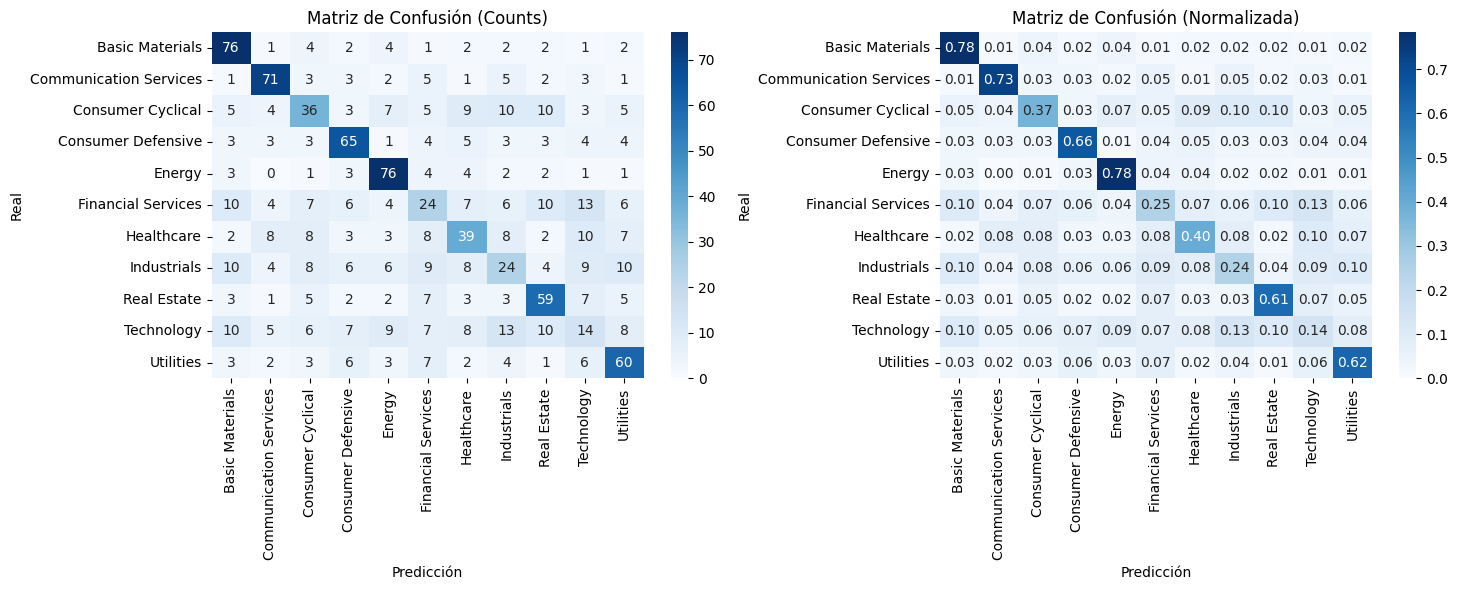

\nüìã REPORTE DE CLASIFICACI√ìN DETALLADO:
                        precision    recall  f1-score   support

       Basic Materials       0.60      0.78      0.68        97
Communication Services       0.69      0.73      0.71        97
     Consumer Cyclical       0.43      0.37      0.40        97
    Consumer Defensive       0.61      0.66      0.64        98
                Energy       0.65      0.78      0.71        97
    Financial Services       0.30      0.25      0.27        97
            Healthcare       0.44      0.40      0.42        98
           Industrials       0.30      0.24      0.27        98
           Real Estate       0.56      0.61      0.58        97
            Technology       0.20      0.14      0.17        97
             Utilities       0.55      0.62      0.58        97

              accuracy                           0.51      1070
             macro avg       0.48      0.51      0.49      1070
          weighted avg       0.48      0.51      0.49     

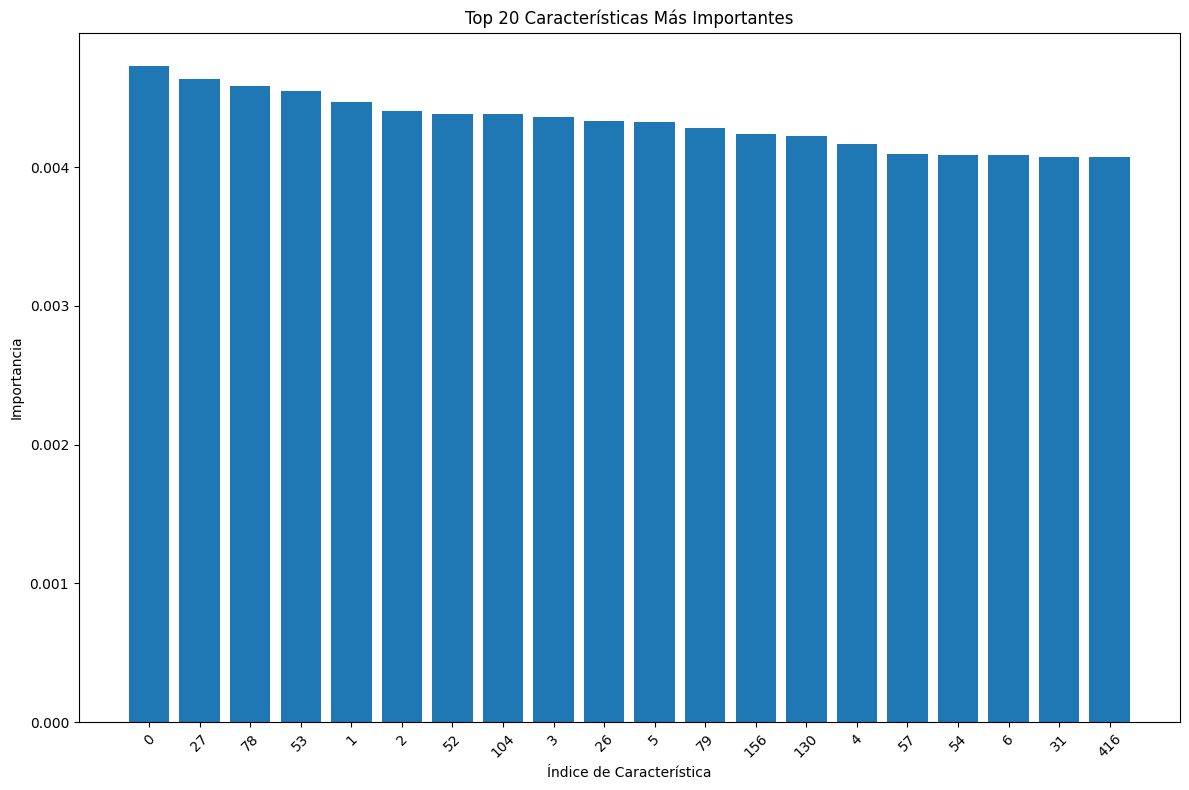

üìä Top 5 caracter√≠sticas m√°s importantes:
  Feature 0: 0.0047
  Feature 27: 0.0046
  Feature 78: 0.0046
  Feature 53: 0.0046
  Feature 1: 0.0045
\nüé≤ AN√ÅLISIS DE CONFIANZA DE PREDICCIONES:


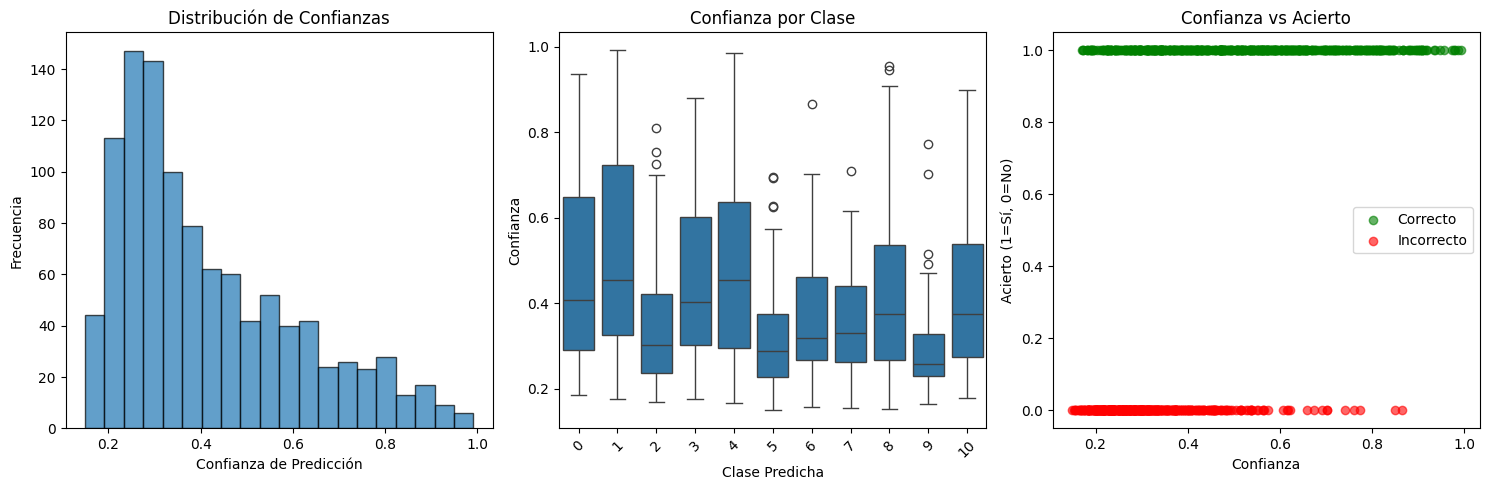

Confianza promedio: 0.415
Confianza m√≠nima: 0.149
Confianza m√°xima: 0.992
\n‚ö†Ô∏è  761 predicciones con confianza < 0.5
Clases de baja confianza: 0     76
2     73
8     73
10    72
5     72
6     70
3     68
9     68
7     66
4     65
1     58
Name: count, dtype: int64
\nüìà AN√ÅLISIS DE CURVAS DE APRENDIZAJE:


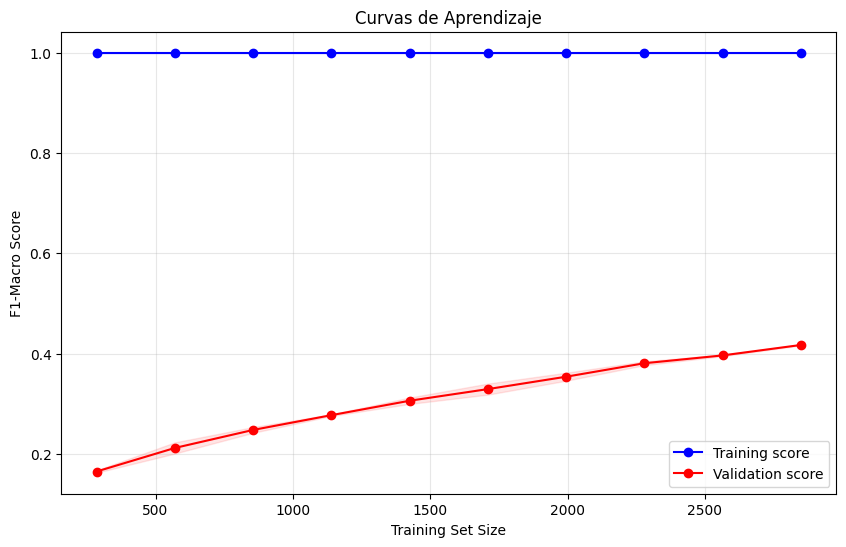

‚úÖ An√°lisis completo terminado!


In [17]:
# =======================================================
# üìä AN√ÅLISIS AVANZADO Y INTERPRETABILIDAD
# =======================================================

# 1. MATRIZ DE CONFUSI√ìN MEJORADA
print("üìä An√°lisis detallado del mejor modelo...")

# Usar el mejor modelo
y_pred_best = best_model.predict(X_test_opt)
y_pred_proba = best_model.predict_proba(X_test_opt)

# Matriz de confusi√≥n con m√°s detalles
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusi√≥n absoluta
cm = confusion_matrix(y_test_opt, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('Matriz de Confusi√≥n (Counts)')
axes[0].set_xlabel('Predicci√≥n')
axes[0].set_ylabel('Real')

# Matriz de confusi√≥n normalizada
cm_norm = confusion_matrix(y_test_opt, y_pred_best, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Matriz de Confusi√≥n (Normalizada)')
axes[1].set_xlabel('Predicci√≥n')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Reporte de clasificaci√≥n detallado
print("\\nüìã REPORTE DE CLASIFICACI√ìN DETALLADO:")
print("=" * 60)
print(classification_report(y_test_opt, y_pred_best, target_names=le.classes_))

# 2. AN√ÅLISIS DE IMPORTANCIA DE CARACTER√çSTICAS
print("\\nüéØ AN√ÅLISIS DE IMPORTANCIA DE CARACTER√çSTICAS:")

# Extraer el modelo Random Forest del pipeline
if 'rf' in best_model.named_steps:
    rf_model = best_model.named_steps['rf']
elif 'voting' in best_model.named_steps:
    # Para voting classifier, usar el RF interno
    rf_model = best_model.named_steps['voting'].estimators_[0]

if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    
    # Top 20 caracter√≠sticas m√°s importantes
    indices = np.argsort(importances)[::-1][:20]
    
    plt.figure(figsize=(12, 8))
    plt.title('Top 20 Caracter√≠sticas M√°s Importantes')
    plt.bar(range(20), importances[indices[:20]])
    plt.xlabel('√çndice de Caracter√≠stica')
    plt.ylabel('Importancia')
    plt.xticks(range(20), indices[:20], rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"üìä Top 5 caracter√≠sticas m√°s importantes:")
    for i in range(5):
        idx = indices[i]
        print(f"  Feature {idx}: {importances[idx]:.4f}")

# 3. AN√ÅLISIS DE CONFIANZA DE PREDICCIONES
print("\\nüé≤ AN√ÅLISIS DE CONFIANZA DE PREDICCIONES:")

# Calcular confianza (m√°xima probabilidad)
confidences = np.max(y_pred_proba, axis=1)

plt.figure(figsize=(15, 5))

# Subplot 1: Distribuci√≥n de confianzas
plt.subplot(1, 3, 1)
plt.hist(confidences, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Confianza de Predicci√≥n')
plt.ylabel('Frecuencia')
plt.title('Distribuci√≥n de Confianzas')

# Subplot 2: Confianza por clase predicha
plt.subplot(1, 3, 2)
conf_by_class = pd.DataFrame({'confidence': confidences, 'predicted': y_pred_best})
sns.boxplot(data=conf_by_class, x='predicted', y='confidence')
plt.xlabel('Clase Predicha')
plt.ylabel('Confianza')
plt.title('Confianza por Clase')
plt.xticks(rotation=45)

# Subplot 3: Confianza vs Acierto
plt.subplot(1, 3, 3)
correct = (y_test_opt == y_pred_best)
plt.scatter(confidences[correct], [1]*sum(correct), alpha=0.6, label='Correcto', color='green')
plt.scatter(confidences[~correct], [0]*sum(~correct), alpha=0.6, label='Incorrecto', color='red')
plt.xlabel('Confianza')
plt.ylabel('Acierto (1=S√≠, 0=No)')
plt.title('Confianza vs Acierto')
plt.legend()

plt.tight_layout()
plt.show()

# Estad√≠sticas de confianza
print(f"Confianza promedio: {confidences.mean():.3f}")
print(f"Confianza m√≠nima: {confidences.min():.3f}")
print(f"Confianza m√°xima: {confidences.max():.3f}")

# Identificar predicciones de baja confianza
low_conf_threshold = 0.5
low_conf_mask = confidences < low_conf_threshold
if low_conf_mask.any():
    print(f"\\n‚ö†Ô∏è  {sum(low_conf_mask)} predicciones con confianza < {low_conf_threshold}")
    print("Clases de baja confianza:", pd.Series(y_pred_best[low_conf_mask]).value_counts())

# 4. CURVAS DE APRENDIZAJE
print("\\nüìà AN√ÅLISIS DE CURVAS DE APRENDIZAJE:")

from sklearn.model_selection import learning_curve

# Calcular curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_opt, y_train_opt, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='f1_macro', n_jobs=-1
)

# Plotear curvas
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training score', color='blue')
plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1, color='blue')

plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation score', color='red')
plt.fill_between(train_sizes, val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('F1-Macro Score')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("‚úÖ An√°lisis completo terminado!")